In [1]:
import os
import torch
import numpy as np
import tempfile
from contextlib import nullcontext

from mast3r.demo import get_args_parser, main_demo, get_reconstructed_scene, set_scenegraph_options
from dust3r.utils.device import to_numpy

from mast3r.cloud_opt.sparse_ga import sparse_global_alignment

from mast3r.model import AsymmetricMASt3R
from mast3r.utils.misc import hash_md5

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.demo import set_print_with_timestamp

import matplotlib.pyplot as plt

import os
from scipy.io import savemat
import argparse

%load_ext autoreload
%autoreload 2

/home/manuelf/mast3r/dust3r/dust3r/cloud_opt/base_opt.py:278: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [26]:
from dust3r.utils.image import load_images
import copy

outdir = "./output"
device = "cuda:1"
#device = "cpu"
#im_dir = "./images_in/piv"
#im_dir = "./images_in/train"
im_dir = "./images_in/DAVIS/JPEGImages/480p/train"
#im_dir = "./images_in/DAVIS/JPEGImages/480p/car-roundabout"
#im_dir = "./images_in/DAVIS/JPEGImages/480p/car-turn"
im_dir = "./images_in/copitec"

#make filelist be a list of all the files in the directory
#filelist = [os.path.join(filelist, f) for f in os.listdir(filelist)]
#print(filelist)

#load images

imgs = load_images(im_dir, size=512, verbose=1, skip_frames=7, ground_truth=False)
filelist = [img["path"] for img in imgs]

if len(imgs) == 1:
        imgs = [imgs[0], copy.deepcopy(imgs[0])]
        imgs[1]['idx'] = 1
        filelist = [im_dir[0], im_dir[0] + '_2']
        

imgs = imgs[:2]

>> Loading images from ./images_in/copitec
 - adding 00000.png with resolution 1920x1080 --> 512x288
 - adding 00008.png with resolution 1920x1080 --> 512x288
 - adding 00016.png with resolution 1920x1080 --> 512x288
 - adding 00024.png with resolution 1920x1080 --> 512x288
 - adding 00032.png with resolution 1920x1080 --> 512x288
 - adding 00040.png with resolution 1920x1080 --> 512x288
 - adding 00048.png with resolution 1920x1080 --> 512x288
 - adding 00056.png with resolution 1920x1080 --> 512x288
 - adding 00064.png with resolution 1920x1080 --> 512x288
 - adding 00072.png with resolution 1920x1080 --> 512x288
 (Found 10 images)


In [3]:
model = AsymmetricMASt3R.from_pretrained("./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth").to(device)
#model = AsymmetricMASt3R.from_pretrained("./docker/files/checkpoints/MonST3R_PO-TA-S-W_ViTLarge_BaseDecoder_512_dpt.pth").to(device)

... loading model from ./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


len of pairs 2


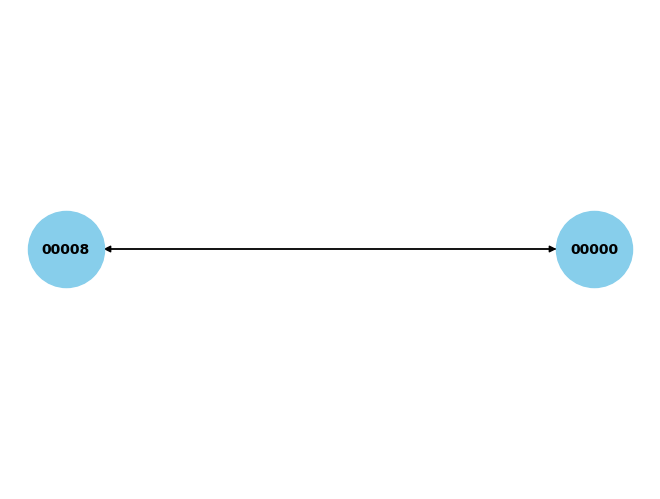

In [27]:
#test make_pairs
from dust3r.image_pairs import make_pairs
from auxiliar.viz_graph import viz_graph

#scenegraphy
scenegraph_type="swin"
win_cyclic = False
winsize = 2
refid = 0

scene_graph_params = [scenegraph_type]
if scenegraph_type in ["swin", "logwin"]:
    scene_graph_params.append(str(winsize))
elif scenegraph_type == "oneref":
    scene_graph_params.append(str(refid))
if scenegraph_type in ["swin", "logwin"] and not win_cyclic:
    scene_graph_params.append('noncyclic')
scene_graph = '-'.join(scene_graph_params)

pairs = make_pairs(imgs, scene_graph=scene_graph, prefilter=None, symmetrize=True)

print("len of pairs", len(pairs))

file_names = [im["path"] for im in imgs]

viz_graph(file_names, pairs)

In [ ]:
from auxiliar.scene_to_data import SceneToData
import time

# cache to store previous inference results
delete_cache = True
if delete_cache:
    os.system(f"rm -rf {outdir}/cache")
cache_dir = os.path.join(outdir, 'cache')
os.makedirs(cache_dir, exist_ok=True)

# optimization level
optim_level = "coarse"
niter2 = 0 if optim_level == "coarse" else 200

scene, _, res_coarse, res_fine = sparse_global_alignment(filelist, pairs, cache_dir,
                                    model, lr1=0.07 , niter1=500, lr2=0.014, niter2=niter2, device=device,
                                    opt_depth='depth' in optim_level, shared_intrinsics=False,
                                    matching_conf_thr=0.5)

#save the scene into mat files and full pcd file with wrld pts
scene_class = SceneToData(scene)
scene_class.save_mat_file(outdir)
scene_class.save_pcd_file(outdir, conf_threshold=0.001)

  0%|                                                                                                          | 0/2 [00:00<?, ?it/s]/home/manuelf/mast3r/mast3r/cloud_opt/sparse_ga.py:602: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
 50%|█████████████████████████████████████████████████                                                 | 1/2 [00:00<00:00,  1.08it/s]/home/manuelf/mast3r/mast3r/cloud_opt/sparse_ga.py:552: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the funct

Inference time: 0.55s, Correspondences time: 0.32s


  0%|                                                                                                          | 0/2 [00:00<?, ?it/s]/home/manuelf/mast3r/mast3r/cloud_opt/sparse_ga.py:667: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on 

init focals = [898.84515 898.84515]


100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 45.76it/s, lr=0.0000, loss=-0.000]
/home/manuelf/mast3r/mast3r/cloud_opt/sparse_ga.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on 

>> final loss = -2.9802320611338473e-08
Final focals = [898.84515 898.84515]
Optimization took 10.932291269302368 s


In [31]:
# dust3r ga + mast3r model
from dust3r.inference import inference
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode
from dust3r.cloud_opt.base_opt import clean_pointcloud
from dust3r.utils.geometry import inv


for pair in pairs:
    continue
    pair[0]["img"][0,:,torch.tensor(pair[0]["gt"]).to(torch.bool)] = 0
    pair[1]["img"][0,:,torch.tensor(pair[1]["gt"]).to(torch.bool)] = 0

output = inference(pairs, model, device, batch_size=1, verbose=True)


mode = GlobalAlignerMode.PointCloudOptimizer if len(imgs) > 2 else GlobalAlignerMode.PairViewer
init_mode = "mst" if len(imgs) > 2 else "known_poses"

scene = global_aligner(output, device=device, mode=mode, verbose=True)

loss = scene.compute_global_alignment(init=init_mode, niter=150, schedule="cosine", lr=0.01)

# better confs
cleaned_confs = clean_pointcloud(scene.get_conf(), scene.get_intrinsics(), inv(scene.get_im_poses()), scene.get_conf(), scene.get_pts3d())

>> Inference with model on 2 image pairs


  0%|                                                                                                       | 0/2 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]


  - conf=2.25 for edge 0-1
  - conf=2.1 for edge 1-0


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.15it/s]


_set_depthmap is ignored in PairViewer
_set_depthmap is ignored in PairViewer


# just check what is the output of just one pair

### Non symmetric inference, just one branch of the network without the cross-attention

In [ ]:
import matplotlib.pyplot as plt
from pypcd4 import PointCloud
from auxiliar.motion_mask import find_mask
from tqdm import tqdm
import copy
import cv2 as cv

new_output = copy.deepcopy(output)

# delete all images in test_images folder
os.system("rm test_images/*")

# load co-tracker model
cotracker = None
if 'cotracker' not in globals():
    cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)
    pass

if "raft" not in globals():
    raft = torch.hub.load('pytorch/vision:v0.15.2', 'raft_large', pretrained=True).to(device)
    raft = raft.eval()

raft_model = raft 
grid_size = 45
epipolarReproj = 1.0
model="homography"
use_GT = True

# encode just one image
with torch.no_grad():

    idx = 0
    for pair in tqdm(pairs):

        if not use_GT:
            mask_out_0 = find_mask(cotracker, device, pair[0], pair[1], grid_size=grid_size,
                                epipolarReproj=epipolarReproj,raft_model=raft, model=model) # image , height x width
            mask_out_1 = find_mask(cotracker, device, pair[1], pair[0], grid_size=grid_size,
                                epipolarReproj=epipolarReproj, raft_model=raft, model=model) # image , height x width
        else: # use ground trith masks
            mask_out_0 = 1-pair[0]["gt"]
            mask_out_1 = 1-pair[1]["gt"]

            
        new_output["pred1"]["conf"][idx, ~torch.tensor(mask_out_0).to(torch.bool)] = 1.0
        new_output["pred2"]["conf"][idx, ~torch.tensor(mask_out_1).to(torch.bool)] = 1.0

        # change input images pixel values 
        pair[0]["img"][0,:,~torch.tensor(mask_out_0).to(torch.bool)] = -1
        pair[1]["img"][0,:,~torch.tensor(mask_out_1).to(torch.bool)] = -1

        new_output["pred1"]["pts3d"][idx, ~torch.tensor(np.repeat(np.expand_dims(mask_out_0,axis=2),3,axis=2)).to(torch.bool)] = 0.0
        new_output["pred2"]["pts3d_in_other_view"][idx, ~torch.tensor(np.repeat(np.expand_dims(mask_out_1,axis=2),3,axis=2)).to(torch.bool)] = 0.0


        #im = (new_output["pred2"]["conf"][idx,:,:].cpu().numpy() - \
        #    np.min(new_output["pred2"]["conf"][idx,:,:].cpu().numpy())) * (255/np.max(new_output["pred2"]["conf"][idx,:,:].cpu().numpy()))
        
        cv.imwrite(f'test_images/conf_mask_{pair[0]["instance"]}_{pair[1]["instance"]}.png', \
                   cv.cvtColor(mask_out_1.astype(np.uint8), cv.COLOR_GRAY2BGR)*100 + cv.cvtColor(pair[1]["img"].squeeze().permute(1,2,0).cpu().numpy()/2 + 0.5, cv.COLOR_BGR2RGB)* 255 / 2 )

        idx += 1


ModuleNotFoundError: No module named 'pypcd4'

In [61]:
from scipy.spatial.transform import Rotation as R
import rerun as rr
from auxiliar.rerun import log_points, log_camera_pose
import time

# Initialize Rerun logging
rr.init("3D Points and Camera Visualization")

cam_poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
colors = [im["img"].squeeze().permute(1,2,0).reshape(-1, 3).detach().cpu().numpy() for im in imgs]
focals = scene.get_focals()
depthmaps = scene.get_depthmaps()

scale_rerun_w = 1.0
rr.notebook_show(width=int(1920*scale_rerun_w), height=int(1080*scale_rerun_w))

conf_thresh = 0.02

confs = scene.get_conf()
#confs = cleaned_confs

# load all 3d points and colors
cat_3d_wrld = np.concatenate([pts3d[timestamp].detach().cpu().numpy().reshape(-1, 3)[(confs[timestamp].detach().cpu().reshape(-1,1)>conf_thresh).squeeze(),:] \
                              for timestamp in range(0, cam_poses.shape[0])])
cat_3d_clr = np.concatenate([((colors[timestamp][(confs[timestamp].detach().cpu().reshape(-1,1)>conf_thresh).squeeze(),:]+1)/2*255).astype(np.uint32).tolist()\
                              for timestamp in range(0, cam_poses.shape[0])])

# downsample points
cat_3d_wrld = cat_3d_wrld[::5]
cat_3d_clr = cat_3d_clr[::5]

# set 3d points as static in the frame_idx timeline
rr.log("world/3d", rr.Points3D(cat_3d_wrld, colors =cat_3d_clr), static=True)


# update all transforms over the timestamps
for timestamp in range(0, cam_poses.shape[0]):

    rr.set_time_sequence("frame_idx", timestamp)

    # wrld to camera TF
    rr.log("world/camera", rr.Transform3D(translation=cam_poses[timestamp][:3, 3].detach().cpu().numpy(), \
                                          rotation=rr.Quaternion(xyzw=R.from_matrix(cam_poses[timestamp][:3, :3].detach().cpu()).as_quat())))
    
    rr.log(f"world/camera{timestamp}", rr.Transform3D(translation=cam_poses[timestamp][:3, 3].detach().cpu().numpy(), \
                                          rotation=rr.Quaternion(xyzw=R.from_matrix(cam_poses[timestamp][:3, :3].detach().cpu()).as_quat())), static=True)
    # pinhole definition
    rr.log("world/camera", rr.Pinhole(width=imgs[timestamp]["img"].shape[3], height=imgs[timestamp]["img"].shape[2], focal_length=float(focals[timestamp].detach().cpu().numpy().squeeze())))

    # image in the pinhole
    rr.log("world/camera/rgb", rr.Image((imgs[timestamp]["img"].detach().cpu().squeeze().permute(1,2,0).numpy()+1)/2))

    # log depthmaps with confidence
    #rr.log("world/camera/depth", rr.DepthImage(depthmaps[timestamp].detach().cpu().numpy()))


Viewer()

In [ ]:
from dust3r.post_process import estimate_focal_knowing_depth 
import cv2 as cv
from tqdm import tqdm

# estimate focal lenght for each pair and the pairwise transformation

idx_pair = 0
tfs = {}



for idx_pair, pair in tqdm(enumerate(pairs),total=len(pairs), ncols=100):   

    #print("between img", pair[0]["instance"], pair[1]["instance"])
    H, W = torch.tensor(pair[0]["img"].shape[2:] )
    pp = torch.tensor([W / 2, H / 2]).to(device)

    focal_length = estimate_focal_knowing_depth(output["pred2"]["pts3d_in_other_view"][idx_pair,:,:,:].unsqueeze(0).to(device) ,\
                                                 pp, focal_mode='weiszfeld')

    K = np.eye(3)
    K[0, 0] = focal_length
    K[1, 1] = focal_length
    K[0, 2] = pp[0]
    K[1, 2] = pp[1]

    #k_global = scene.get_intrinsics()[int(pair[1]["idx"])].detach().cpu().numpy()

    #print(k_global, K)

    #solve the pnp
    pixels = np.mgrid[:int(W), :int(H)].T.astype(np.float32)
    status, R, T, inliers = cv.solvePnPRansac( output["pred2"]["pts3d_in_other_view"][idx_pair,:,:,:].numpy().reshape(-1, 3), \
                                                pixels.reshape(-1,2), K, None, flags=cv.SOLVEPNP_EPNP)   
    
    rot_mat = cv.Rodrigues(R)[0]
    t_vec = T

    if pair[1]["idx"] not in tfs:
        tfs[pair[1]["idx"]] = {}

    tfs[pair[1]["idx"]][pair[0]["idx"]] = np.vstack(( np.hstack((rot_mat, t_vec)), np.array([0, 0, 0, 1]) ))
    
    # REPROJECTION OF 3D POINTS FROM THE FIRST IMAGE TO THE SECOND IMAGE WITH [R|T]
    if np.abs(pair[0]["idx"] - pair[1]["idx"])>=7 and 0:
        #with a known R and T, reproject back the 3d points into the image
        reprojected = cv.projectPoints(output["pred1"]["pts3d"][idx_pair,:,:,:].numpy().reshape(-1, 3), R, T, K, None)[0]

        # create new image with reprojected points in 2d plane

        img = np.zeros((int(H), int(W), 3), dtype=np.float32)

        #saturate to image size values
        reprojected = np.clip(reprojected, 0, np.array([W-1, H-1]))

        img[reprojected.squeeze().astype(int)[:,1], reprojected.squeeze().astype(int)[:,0], :] = pair[0]["img"].squeeze().permute(1,2,0).cpu().numpy()[reprojected.squeeze().astype(int)[:,1], reprojected.squeeze().astype(int)[:,0], :]

        img = img + 1
        img = img / 2
        img = img * 255
        img = img.astype(np.uint8)

        cv.imwrite(f"test_images/{idx_pair}.png", cv.cvtColor((img*0.8).astype(np.uint8) + (0.2*((pair[0]["img"].squeeze().permute(1,2,0)+1)/2*255).numpy()).astype(np.uint8), cv.COLOR_BGR2RGB ))

100%|███████████████████████████████████████████████████████████████| 58/58 [00:18<00:00,  3.14it/s]


In [ ]:
def query_pair_idx (instance1, instance2):
    for idx, pair in enumerate(pairs):
        if pair[0]["idx"] == instance1 and pair[1]["idx"] == instance2:
            return idx
    return -1

def invert_homog_tf(tf):
    tf_inv = np.eye(4)
    tf_inv[:3,:3] = tf[:3,:3].T
    tf_inv[:3,3] = -tf[:3,:3].T @ tf[:3,3]
    return tf_inv

def plot_frame(ax, H, label, scale=0.02, color = 'k'):
    origin = H[:3, 3]
    x_axis = H[:3, 0]
    y_axis = H[:3, 1]
    z_axis = H[:3, 2]

    ax.quiver(*origin, *x_axis, color='r', length=scale, normalize=True)
    ax.quiver(*origin, *y_axis, color='g', length=scale, normalize=True)
    ax.quiver(*origin, *z_axis, color='b', length=scale, normalize=True)
    ax.text(*origin, label, fontsize=12, color=color)


scene.get_pw_scale()

tensor([0.4929, 0.3962, 0.4514, 0.5341, 0.4074, 0.6873, 0.6774, 0.4541, 0.5950,
        0.3643, 0.5036, 0.4780, 0.3880, 0.4165, 0.7105, 0.4712, 0.3988, 0.6021,
        0.4465, 0.6502, 0.4793, 0.4730, 0.4467, 0.6236, 0.4601, 0.5328, 0.6211,
        0.4790, 0.4182, 0.4356, 0.5529, 0.4076, 0.6944, 0.6807, 0.4234, 0.5879,
        0.3807, 0.4745, 0.4661, 0.4014, 0.4225, 0.7161, 0.4561, 0.3957, 0.5858,
        0.4501, 0.6624, 0.4545, 0.4779, 0.4391, 0.6676, 0.4493, 0.5632, 0.6021],
       device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
import rerun as rr
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

scale_rerun_w = 1.0
rr.init("3D Points and Camera Visualization")

# use rerun to see transformation in an inference pair
rr.notebook_show(width=int(1920*scale_rerun_w), height=int(1080*scale_rerun_w))

for idx_pair, pair in tqdm(enumerate(pairs),total=len(pairs), ncols=100):

    if not (idx_pair % 10 == 0):
        continue

    #print("between img", pair[0]["idx"], pair[1]["idx"])

    downsample_factor = 4
    rr.set_time_sequence("idx_pair", idx_pair)

    rr.log(f"pair_0", rr.Transform3D(translation=np.zeros((1,3)), \
                                          rotation=rr.Quaternion(xyzw=np.array([0,0,0,1]))))
        
    rr.log(f"pair_1", rr.Transform3D(translation=tfs[pairs[idx_pair][0]["idx"]][pairs[idx_pair][1]["idx"]][:3, 3], \
                                          rotation=rr.Quaternion(xyzw=R.from_matrix(tfs[pairs[idx_pair][0]["idx"]][pairs[idx_pair][1]["idx"]][:3, :3]).as_quat())))
    
    
    rr.log(f"pair_0/3d", rr.Points3D(torch.reshape(output["pred1"]["pts3d"][idx_pair,:,:,:], (-1,3)).detach().cpu().numpy()[::downsample_factor],\
                                             colors =((torch.reshape(pairs[idx_pair][0]["img"].squeeze().permute(1,2,0),(-1,3))+1)/2*255).detach().cpu().numpy().astype(np.uint32).tolist()[::downsample_factor]))
    
    rr.log(f"pair_0/3d_other", rr.Points3D(torch.reshape(output["pred2"]["pts3d_in_other_view"][idx_pair,:,:,:], (-1,3)).detach().cpu().numpy()[::downsample_factor],\
                                             colors =((torch.reshape(pairs[idx_pair][1]["img"].squeeze().permute(1,2,0),(-1,3))+1)/2*255).detach().cpu().numpy().astype(np.uint32).tolist()[::downsample_factor]))    
    



Viewer()

If not, consider setting `RERUN_NOTEBOOK_ASSET`. Consult https://pypi.org/project/rerun-notebook/0.20.3/ for details.

  0%|                                                                         | 0/6 [00:00<?, ?it/s]


NameError: name 'tfs' is not defined

In [32]:
#use cotracker to generate some tracks
try:
    del pred_tracks
    del pred_visibility
    del cotracker_model
except:
    pass

import gc
gc.collect()

#load model
if 'cotracker_model' not in globals():
    cotracker_model = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)
grid_size = 20

two_frame_tensor = torch.cat([img["img"] for img in imgs], dim=0).unsqueeze(0).to(device)

pred_tracks, pred_visibility = cotracker_model(two_frame_tensor, grid_size=grid_size)


Using cache found in /home/manuelf/.cache/torch/hub/facebookresearch_co-tracker_main


In [34]:
from tqdm import tqdm
import matplotlib.colors as mcolors
from concurrent.futures import ThreadPoolExecutor
import os


pts1 = pred_tracks[0,0,:,:].cpu().numpy()
pts2 = pred_tracks[0,1,:,:].cpu().numpy()

for frame in tqdm(range(0, pred_tracks.shape[1], 1)):
    fig, ax = plt.subplots(figsize=(20,10))
    
    # Show current frame image
    frame_img = (two_frame_tensor[0,frame].cpu().permute(1,2,0).numpy() + 1) / 2
    ax.imshow(frame_img)
    
    # Plot tracks up to current frame
    visible_tracks = int(pred_visibility[0,frame].sum().item())
    for track_idx in range(visible_tracks):
        if pred_visibility[0,frame,track_idx]:
            # Get track history up to current frame
            track_history = pred_tracks[0,:frame+1,track_idx].cpu().numpy()
            
            # Create color gradient from red to blue for track path
            colors = plt.cm.RdYlBu(np.linspace(0, 1, len(track_history)))
            
            # Plot track path with color gradient
            for i in range(len(track_history)-1):
                ax.plot(track_history[i:i+2,0], 
                       track_history[i:i+2,1], 
                       color=colors[i], 
                       linewidth=4, 
                       alpha=0.5)
            
            # Plot current point
            ax.plot(track_history[-1,0], 
                   track_history[-1,1], 
                   'w.', 
                   markersize=3, 
                   markeredgecolor='black')
    
    ax.set_title(f'Frame {frame}')
    ax.axis('off')
    plt.savefig(f'test_images/tracks_frame_{frame:03d}.png', bbox_inches='tight')
    plt.close(fig)


  0%|                                                                                                       | 0/2 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.20it/s]


In [35]:
visible_points = torch.all(pred_visibility.to(torch.int).squeeze(), dim=0)

im_poses = scene.get_im_poses()
H, W = (imgs[0]["img"].shape[2:] )

uv_interest = []
pts3d_interest = []

for idx_frame, pts3d in enumerate( scene.get_pts3d() ):
    
    pts3d_column = torch.reshape ( pts3d , (-1,3) )

    pts3d_wrld_col = im_poses[idx_frame,:,:].squeeze() @ torch.hstack((pts3d_column, torch.ones((pts3d_column.shape[0],1)).to(device))).T

    pts3d_wrld_grid = torch.reshape( pts3d_wrld_col[:3, :], (H, W,3) )

    uv_interest.append( pred_tracks[0,idx_frame,visible_points,:] )
    pts3d_interest.append( pts3d_wrld_grid[uv_interest[idx_frame][:,1].to(torch.int), uv_interest[idx_frame][:,0].to(torch.int), :] )


In [36]:
#calculate optical flow from tracks

tensor_uv = torch.stack(uv_interest)
flow = []
for i in range(0, tensor_uv.shape[0]-1):
    flow.append( (uv_interest[i+1] - uv_interest[i]) )

flow = torch.stack(flow)

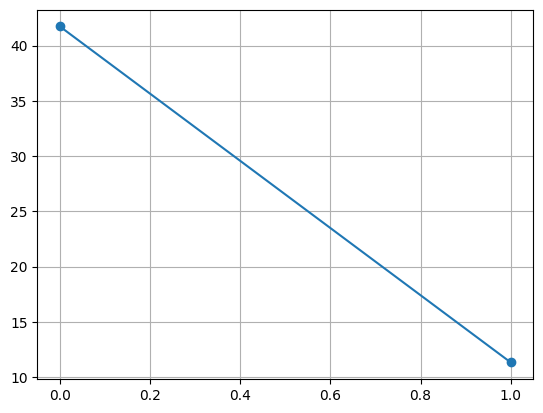

In [37]:
to_try = torch.cat( [ flow[i, : , :] for i in range(0, flow.shape[0])] ,dim=1).T

U, S, V = np.linalg.svd(to_try.detach().cpu().numpy())
plt.plot(S, "-o")
plt.grid()

torch.Size([4, 370])


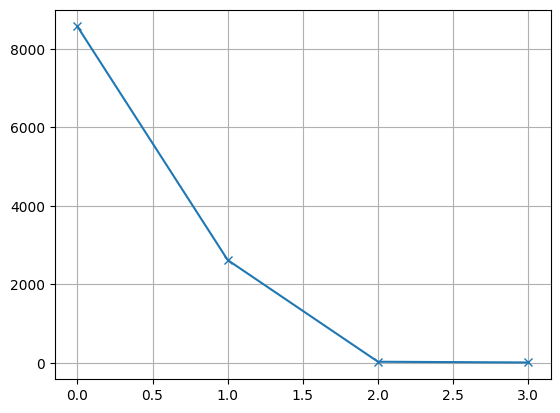

In [38]:
obs_mat = torch.cat(uv_interest, dim=1).T
print(obs_mat.shape)
U, S, V = np.linalg.svd(obs_mat.detach().cpu().numpy() )#- obs_mat.mean(dim=0, keepdim=True).detach().cpu().numpy())


plt.plot(S, "-x")
plt.grid()



In [39]:
from sea_raft.core.raft import RAFT
from sea_raft.config.parser import json_to_args
from torchsummary import summary
from sea_raft.core.utils.utils import load_ckpt

import cv2 as cv

raft = RAFT(json_to_args("./sea_raft/config/eval/spring-M.json")).to(device)
load_ckpt(raft, "sea_raft/Tartan-C-T-TSKH-spring540x960-M.pth")


In [41]:
im1 = imgs[0]["img"].squeeze().expand(1,-1,-1,-1).to(device)
im2 = imgs[1]["img"].squeeze().expand(1,-1,-1,-1).to(device)


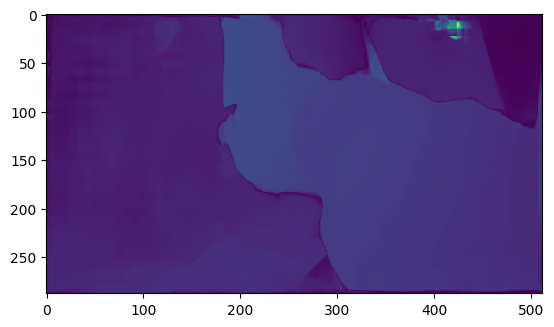

In [42]:

flow = raft(im1,
            im2)


plt.imshow (
    torch.norm( flow["final"].squeeze(), dim= 0).detach().cpu().numpy()
)

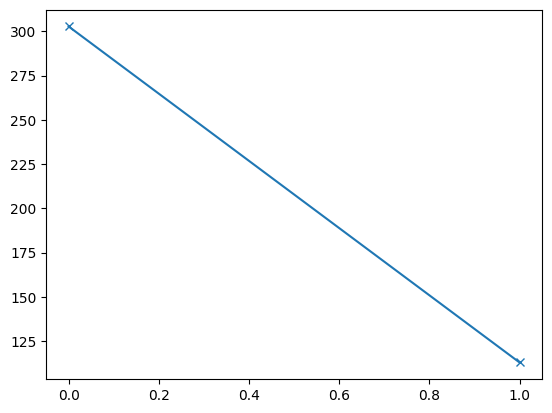

In [44]:
video_flow = []
for idx_frame, pts3d in enumerate(imgs[1:10]):
    pass

    im1 = imgs[idx_frame-1]["img"].to(device)
    im2 = imgs[idx_frame]["img"].to(device)

    flow = raft(im1, im2)["final"].squeeze().permute(1,2,0)

    #create a pixel grid
    H, W = im1.shape[2:]
    if idx_frame == 0:
        grid = torch.meshgrid([torch.arange(H), torch.arange(W)])
        grid = torch.stack(grid, dim=-1).to(device)

    video_flow.append(flow.detach().cpu().numpy())
    grid = grid + flow
    


to_stack = torch.stack([torch.tensor(flow).squeeze() for flow in video_flow], dim=0)


w = torch.reshape( torch.reshape( to_stack , (to_stack.shape[0], -1, 2) ).permute(2,0,1), (2, -1))

U, S, V = np.linalg.svd(w.detach().cpu().numpy()[:, ::10] )#- obs_mat.mean(dim=0, keepdim=True).detach().cpu().numpy())
plt.plot(S, "-x")



In [44]:
def track_points(flow_list, seed_points):
    """
    Track given seed points across frames using optical flow fields.

    Parameters:
    - flow_list: List of optical flow fields [flow_t0, flow_t1, ..., flow_tN-1], each of shape (H, W, 2).
    - seed_points: List of (x, y) coordinates to track.

    Returns:
    - tracks: List of lists containing tracked points per seed.
    """
    num_frames = len(flow_list)
    tracks = [[p] for p in seed_points]  # Initialize tracks

    for t in range(num_frames):
        flow = flow_list[t]  # Optical flow at frame t

        for i, track in enumerate(tracks):
            x, y = track[-1]
            h, w = flow.shape[:2]

            # Check if still in bounds
            if 0 <= x < w and 0 <= y < h:
                u, v = flow[int(y), int(x)]  # Get flow vector
                new_x, new_y = x + u, y + v

                # Check bounds again
                if 0 <= new_x < w and 0 <= new_y < h:
                    track.append((new_x, new_y))
                else:
                    break  # Stop tracking if out of bounds
            else:
                break  # Stop tracking if out of bounds

    return tracks

tracks = track_points( video_flow, [(300,200), (200,200), (150,150)])

tracks[2]

[(150, 150),
 (np.float32(168.79733), np.float32(146.1442)),
 (np.float32(169.60985), np.float32(148.49203)),
 (np.float32(170.85275), np.float32(150.60858)),
 (np.float32(172.20033), np.float32(152.89752)),
 (np.float32(173.65622), np.float32(155.13147)),
 (np.float32(175.31445), np.float32(157.48099)),
 (np.float32(177.09181), np.float32(160.30699)),
 (np.float32(179.02832), np.float32(162.8267)),
 (np.float32(180.2581), np.float32(165.1301))]

In [166]:
def draw_tracks(img, tracks):
    for track in tracks:
        points = np.array(track, dtype=np.int32)
        for i in range(1, len(points)):
            img = cv.line(img, tuple(points[i-1]), tuple(points[i]), (0, 255, 0), 2)
    return img

img = draw_tracks(np.ascontiguousarray( (((imgs[0]["img"].squeeze().permute(1,2,0).detach().cpu().numpy()+1)/2)*255), dtype=np.uint8)
                  , tracks)



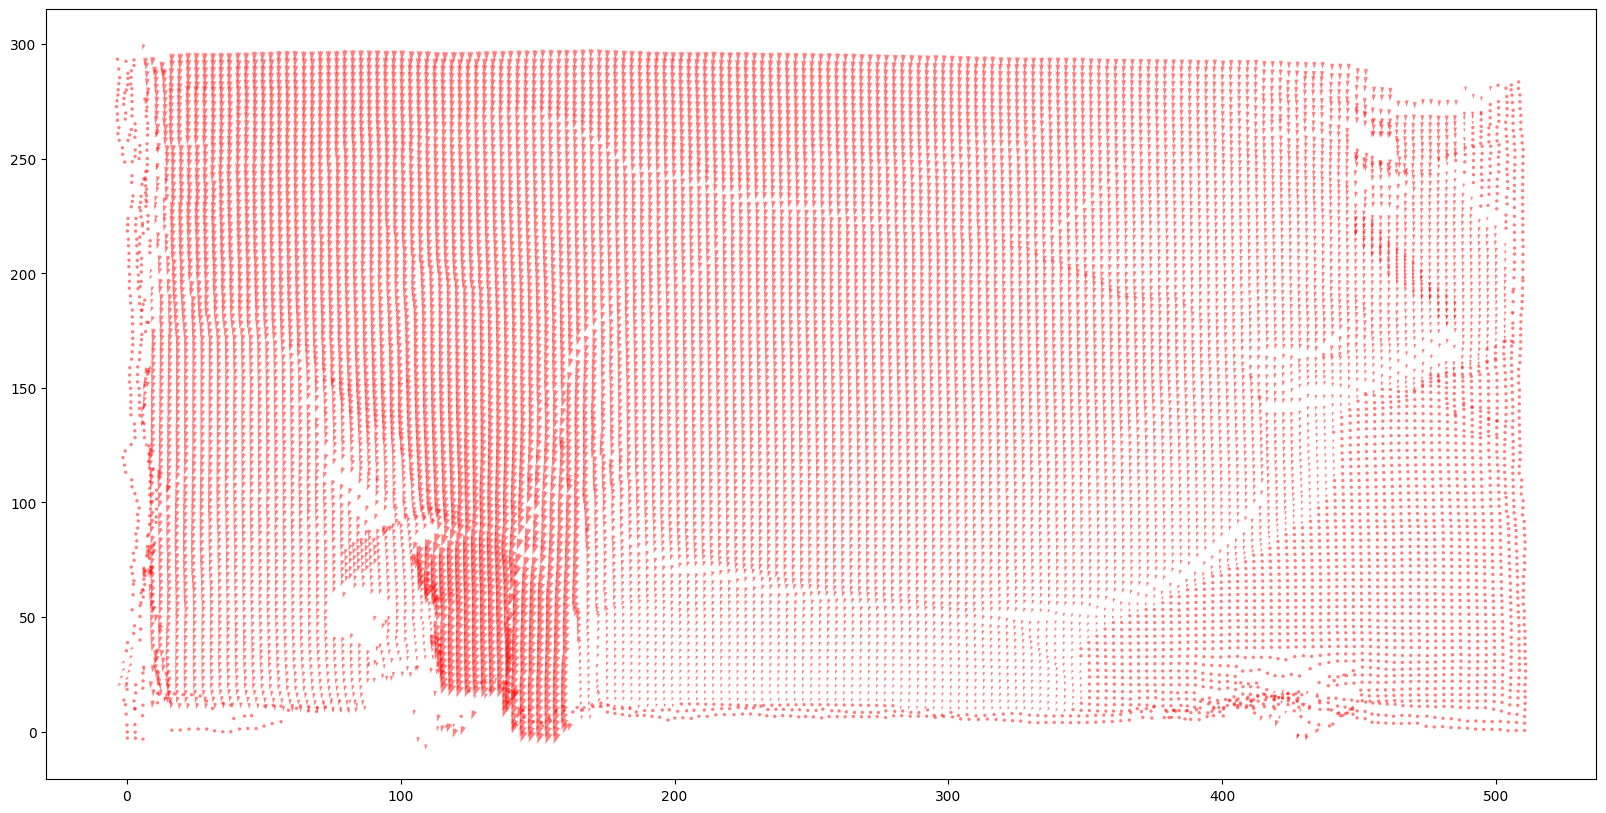

In [164]:
# display a subset of the flow field from the video_flow with a quiver plot

plt.figure(figsize=(20, 10))
#plt.imshow(img)

# quiver plot of the quiver field

plt.quiver(grid[::3,::3, 1].detach().cpu().numpy(), grid[::3,::3, 0].detach().cpu().numpy(),
 flow[::3,::3, 1].detach().cpu().numpy(), flow[::3,::3, 0].detach().cpu().numpy(), color='r', alpha=0.5)

In [157]:
flow[::3,::3, 0].shape

torch.Size([96, 171])